# Topicando (AlPHA)
Topicando es un proyecto que busca ayudar a obtener los tópicos más comentados por un grupo de personas, obteniendo palabras clave en forma de ranking y grafos, para poder analizar necesidades, reclamos, comentarios, tendencias e ideas de la comunidad de forma masiva.

En base a un array de frases como input se procesarán y analizarán los datos recolectados para poder tener un contexto de un tema de debate o discusión, siendo asi que:
- Presenta en una lista ordenada de mayor a menor las palabras más utilizadas diferenciadas con stemming o lemmatizing
- En base a las x palabras más usadas escogidas por estadistica o por número fijo, se crean clusters con KNN, KMeans, etc o solo con que contengan a esta palabra y se muestran grafos por cada palabra elegida como centroide
- De cada cluster o agrupación se debe mostrar las palabras más usadas

## Imports

In [1]:
import spacy
from unidecode import unidecode
from string import punctuation 
from nltk.corpus import stopwords
from collections import Counter
from spacy.matcher import Matcher 
from spacy.tokens import Span

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import scipy

In [3]:
nlp = spacy.load('es_core_news_md')

## Functions

### Most Used Words

In [49]:
def getMostUsedWords(phrases, num):
    fullText = ""
    for phrase in phrases:
        fullText += (phrase + " ")
    doc = nlp(fullText)
    
    words = [token.text
        for token in doc
        if not token.is_stop and not token.is_punct]

    word_freq = Counter(words)
    common_words = word_freq.most_common(num)
    return common_words

def getMostUsedWordsLenma(phrases, num):
    fullText = ""
    for phrase in phrases:
        fullText += (str(phrase) + " ")
    doc = nlp(fullText)
    
    words = [token.lemma_
        for token in doc
        if not token.is_stop and not token.is_punct]

    word_freq = Counter(words)
    common_words = word_freq.most_common(num)
    return common_words

def getWordCount(words):
    dictWords = {}
    for word in words:
        if word not in dictWords.keys():
            dictWords[word] = 1
        else:
            dictWords[word] += 1
    return dictWords

### Knowledge Graph

In [5]:
# No siempre son 2 entidades
def getEntities(phrases):
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    
  prv_tok_text = ""   

  prefix = ""
  modifier = ""

  prv_token = None

  print("TEXTO  LEMMA  POS  TAG  DEP  SHAPE")
  for tok in nlp(phrases):
    print(tok.text, tok.lemma_, tok.pos_, tok.tag_, tok.dep_, tok.shape_)
    #print(tok.text + " > " + tok.dep_ + " > " + tok.lemma_)
    if tok.dep_ != "punct":
      if tok.dep_ == "compound":
        prefix = tok.text
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      if (tok.dep_.find("subj") == True or tok.dep_ == "subj") and tok.pos_ != "PRON":
        ent1 = modifier + " " + prefix + " "+ tok.lemma_
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""   
      if tok.dep_.find("obj") == True:
        ent2 = modifier + " " + prefix + " " + tok.lemma_
      if tok.dep_ == "obj":
        ent2 = tok.lemma_
      if ent1.strip() == "" and ent2.find(tok.lemma_) == -1:
        print("ent1 que o perro >> ",tok.lemma_)
        if tok.dep_.find("mod") == True and tok.pos_ == "ADJ":
          ent1 = tok.lemma_
        if tok.pos_ == "NOUN":
          ent1 = tok.lemma_
      if ent2.strip() == "" and ent1.find(tok.lemma_) == -1:
        if tok.dep_.find("mod") == True and tok.pos_ == "ADJ":
          ent2 = tok.lemma_
        if tok.pos_ == "ADJ":
          ent2 = tok.lemma_
        if tok.pos_ == "NOUN":
          ent2 = tok.lemma_
        if (prv_token != None and prv_token.pos_ == "AUX") and (tok.pos_ == "VERB" or tok.pos_ == "ADJ"):
          ent2 = tok.lemma_
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
      prv_token = tok

  return [ent1.strip(), ent2.strip()]

In [6]:
# TRAER TAMBIEN UN ARRAY DE LOS DISTINTOS VERBOS Y SE USEN LOS 2
def getRelation(sent):
    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)
 
    pattern2 = [
        {'POS':'VERB','OP':"?"},
        {'POS':'AUX','OP':"?"},
    ]

    #matcher.add("matching_1", [pattern, pattern2]) 
    matcher.add("matching_1", [pattern2]) 
    matches = matcher(doc)
    print(matches)

    if len(matches) == 0:
        return "haber"

    k = len(matches) - 1

    print(doc[matches[0][1]:matches[0][2]])
    print(doc[matches[k][1]:matches[k][2]])
    span = doc[matches[k][1]:matches[k][2]] 

    return(span.lemma_)

## Data

In [27]:
data = pd.read_csv('./sugerencias-y-quejas-de-los-ciudadanos (1).csv',delimiter=';')
data = data.dropna()
data[data['Referencia'].apply(lambda x: isinstance(x, (str, bytes)))]
data

,Tipo,Estado,F.Solicitud,Origen,Unidad,Provincia,Referencia
0,Queja,Contestado,2021-12-29,WEB,CONSEJERIA DE FOMENTO Y MEDIO AMBIENTE,LEÓN,Falta de respuesta a solicitud
1,Queja,Contestado,2021-12-23,12,CONSEJERIA DE FOMENTO Y MEDIO AMBIENTE,SERVICIOS CENTRALES,Notificaciones sin indicación del titular al q...
2,Queja,Contestado,2021-12-22,WEB,CONSEJERIA DE FOMENTO Y MEDIO AMBIENTE,SERVICIOS CENTRALES,SOLICITA REVISIÓN DE ALTURA MÁXIMA DE EDIFICAC...
3,Queja,Contestado,2021-12-20,WEB,CONSEJERIA DE FOMENTO Y MEDIO AMBIENTE,ZAMORA,normas subsidiarias municikpales consistente e...
4,Sugerencia,Contestado,2021-12-17,12,CONSEJERIA DE FOMENTO Y MEDIO AMBIENTE,SERVICIOS CENTRALES,BUZÓN NOTIFICACIONES ELECTRÓNICAS
...,...,...,...,...,...,...,...
162,Queja,Contestado,2021-01-14,WEB,CONSEJERIA DE FOMENTO Y MEDIO AMBIENTE,SEGOVIA,El interesado se queja porque el autobús de la...
163,Queja,Contestado,2021-01-14,12,CONSEJERIA DE FOMENTO Y MEDIO AMBIENTE,BURGOS,No limpieza de carretera BU-945
164,Queja,Contestado,2021-01-10,LIBRO,CONSEJERIA DE FOMENTO Y MEDIO AMBIENTE,LEÓN,Normalidad Post-covid
165,Queja,Contestado,2021-01-09,WEB,CONSEJERIA DE FOMENTO Y MEDIO AMBIENTE,SERVICIOS CENTRALES,Diámetro escaso tuberías agua ZA-925


In [28]:
phrases = [ phrase.lower() for phrase in data.iloc[:,6].values]
phrases

['falta de respuesta a solicitud',
 'notificaciones sin indicación del titular al que van dirigidas',
 'solicita revisión de altura máxima de edificación en la cisterniga (vallladolid)',
 'normas subsidiarias municikpales consistente en la modificacion el ambito desarrolo del area especial ae.ps-4 y re¡mision a la comision de urbanismo.',
 'buzón notificaciones electrónicas',
 'no funciona la máquina de bonos de transporte de la estación de autobuses',
 'cita',
 'incidencias en la carretera za-504, que ha sido recientemente rehabilitada',
 'exigencia de uso de navegador internet explorer para trámites electrónicos',
 'transporte a la demanda. merindades',
 'no usar las mascarillas en el lugar de trabajo',
 'señalización en entrada carretera a peñaranda de bracamonte',
 'darse de alta en bec mediante sistema cl@ve',
 'notificaciones electrónicas',
 'que en medio ambiente no ha sido atendida.',
 'queja relacionada con la presentada el día 8 noviembre 2021',
 'falta de aviso en notificaci

In [9]:
#print(phrases)
print(getMostUsedWords(phrases,10))
print(getMostUsedWordsLenma(phrases,10))

[('escolar', 13), ('cierre', 7), ('ceip', 6), ('infantil', 6), ('solicitud', 5), ('ies', 5), ('queja', 5), ('trato', 5), ('transporte', 5), ('programa', 5)]
[('escolar', 14), ('centro', 7), ('cerrar', 6), ('ceip', 6), ('programa', 6), ('infantil', 6), ('comedor', 5), ('solicitud', 5), ('ies', 5), ('quejar', 5)]


In [10]:
for phrase in phrases:
    print(phrase)
    print(getEntities(phrase))
    print(getRelation(phrase))
    print("\n")

ayudas becas comedor centros docentes concertados
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
ayudas ayuda NOUN NOUN ROOT xxxx
ent1 que o perro >>  ayuda
becas beca ADJ ADJ amod xxxx
comedor comedor NOUN NOUN amod xxxx
centros centro NOUN NOUN appos xxxx
docentes docente ADJ ADJ amod xxxx
concertados concertado ADJ ADJ amod xxxx
['ayuda', 'beca']
[]
haber


rechazado por ser cuestión de la consejería de educación. becas
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
rechazado rechazado ADJ ADJ ROOT xxxx
ent1 que o perro >>  rechazado
por por ADP ADP mark xxx
ent1 que o perro >>  por
ser ser AUX AUX cop xxx
ent1 que o perro >>  ser
cuestión cuestión NOUN NOUN xcomp xxxx
ent1 que o perro >>  cuestión
de de ADP ADP case xx
la el DET DET det xx
consejería consejería NOUN NOUN nmod xxxx
de de ADP ADP case xx
educación educación NOUN NOUN nmod xxxx
. . PUNCT PUNCT punct .
becas beca NOUN NOUN ROOT xxxx
['cuestión', 'rechazado']
[(11840699188806025751, 2, 3)]
ser
ser
ser


no está de acuerdo con cantar villancico

servicio servicio NOUN NOUN ROOT xxxx
ent1 que o perro >>  servicio
de de ADP ADP case xx
comedor comedor NOUN NOUN nmod xxxx
escolar escolar ADJ ADJ amod xxxx
['servicio', 'comedor']
[]
haber


desacuerdo no prestar servicio continuadores
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
desacuerdo desacuerdo NOUN NOUN ROOT xxxx
ent1 que o perro >>  desacuerdo
no no ADV ADV advmod xx
prestar prestar VERB VERB csubj xxxx
servicio servicio NOUN NOUN obj xxxx
continuadores continuador ADJ ADJ amod xxxx
['no  prestar', 'servicio']
[(11840699188806025751, 2, 3)]
prestar
prestar
prestar


error en citacion vacuna covid
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
error error NOUN NOUN ROOT xxxx
ent1 que o perro >>  error
en en ADP ADP case xx
citacion citacion PROPN PROPN nmod xxxx
vacuna vacunir VERB VERB case xxxx
covid covid PROPN PROPN nmod xxxx
['error', '']
[(11840699188806025751, 3, 4)]
vacuna
vacuna
vacunir


vacunacion covid-19
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
vacunacion vacunacion PROPN PROPN ROOT xxxx


estructura estructura NOUN NOUN ROOT xxxx
ent1 que o perro >>  estructura
pasiva pasivo ADJ ADJ amod xxxx
en en ADP ADP case xx
libros libro NOUN NOUN nmod xxxx
texto texto ADJ ADJ amod xxxx
ingles ingl ADJ ADJ amod xxxx
['estructura', 'pasivo']
[]
haber


solcitudes ciclo fp
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
solcitudes solcitud ADJ ADJ amod xxxx
ent1 que o perro >>  solcitud
ciclo ciclo NOUN NOUN ROOT xxxx
fp fp PROPN PROPN appos xx
['solcitud', 'ciclo']
[]
haber


ceo atenea bilingüe
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
ceo ceo PROPN PROPN nsubj xxx
atenea atenear VERB VERB ROOT xxxx
bilingüe bilingüe PROPN PROPN obj xxxx
['ceo', 'bilingüe']
[(11840699188806025751, 1, 2)]
atenea
atenea
atenear


reducción jornada escolar junio y septiembre.
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
reducción reducción NOUN NOUN ROOT xxxx
ent1 que o perro >>  reducción
jornada jornada NOUN NOUN amod xxxx
escolar escolar ADJ ADJ amod xxxx
junio junio NOUN NOUN appos xxxx
y y CCONJ CCONJ cc x
septiembre septiem

en en ADP ADP case xx
ent1 que o perro >>  en
ninguno ninguno PRON PRON obl xxxx
ent1 que o perro >>  ninguno
de de ADP ADP case xx
ent1 que o perro >>  de
los el DET DET det xxx
ent1 que o perro >>  el
documentos documento NOUN NOUN nmod xxxx
ent1 que o perro >>  documento
figura figurar VERB VERB ROOT xxxx
que que PRON PRON mark xxx
tuviese tener VERB VERB ccomp xxxx
que que SCONJ SCONJ cc xxx
ir ir AUX AUX conj xx
acompañada acompañado ADJ ADJ obj xxxx
por por ADP ADP case xxx
padre padre NOUN NOUN obj xxxx
, , PUNCT PUNCT punct ,
madre madre NOUN NOUN appos xxxx
o o CCONJ CCONJ cc x
tutor tutor NOUN NOUN conj xxxx
. . PUNCT PUNCT punct .
['documento', 'padre']
[(11840699188806025751, 5, 6), (11840699188806025751, 7, 8), (11840699188806025751, 9, 10)]
figura
ir
ir


incidencia aplicación comedores escolares
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
incidencia incidencia NOUN NOUN amod xxxx
ent1 que o perro >>  incidencia
aplicación aplicación NOUN NOUN nmod xxxx
comedores comedor NOUN NOUN

In [29]:
entity_pairs = []

for i in phrases:
    entity_pairs.append(getEntities(i))

relations = [getRelation(i) for i in phrases]

TEXTO  LEMMA  POS  TAG  DEP  SHAPE
falta falta NOUN NOUN ROOT xxxx
ent1 que o perro >>  falta
de de ADP ADP case xx
respuesta respuesta NOUN NOUN nmod xxxx
a a ADP ADP case x
solicitud solicitud NOUN NOUN nmod xxxx
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
notificaciones notificación NOUN NOUN ROOT xxxx
ent1 que o perro >>  notificación
sin sin ADP ADP case xxx
indicación indicación NOUN NOUN nmod xxxx
del del ADP ADP case xxx
titular titular NOUN NOUN nmod xxxx
al al ADP ADP case xx
que que PRON PRON obl xxx
van ir VERB VERB acl xxx
dirigidas dirigido ADJ ADJ amod xxxx
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
solicita solicitar VERB VERB ROOT xxxx
ent1 que o perro >>  solicitar
revisión revisión NOUN NOUN obj xxxx
de de ADP ADP case xx
ent1 que o perro >>  de
altura altura NOUN NOUN nmod xxxx
ent1 que o perro >>  altura
máxima máximo ADJ ADJ amod xxxx
de de ADP ADP case xx
edificación edificación NOUN NOUN nmod xxxx
en en ADP ADP case xx
la el DET DET det xx
cisterniga cisterniga NOUN NOUN nmod xx

notificación notificación NOUN NOUN ROOT xxxx
ent1 que o perro >>  notificación
electrónica electrónico ADJ ADJ amod xxxx
. . PUNCT PUNCT punct .
enlace enlace NOUN NOUN ROOT xxxx
al al ADP ADP case xx
nuevo nuevo ADJ ADJ amod xxxx
sistema sistema NOUN NOUN nmod xxxx
de de ADP ADP case xx
notificaciones notificación NOUN NOUN nmod xxxx
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
retraso retraso NOUN NOUN ROOT xxxx
ent1 que o perro >>  retraso
autobus autobus ADJ ADJ amod xxxx
de de ADP ADP case xx
santervas santerva NOUN NOUN nmod xxxx
de de ADP ADP case xx
campos campo NOUN NOUN nmod xxxx
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
unificación unificación NOUN NOUN ROOT xxxx
ent1 que o perro >>  unificación
criterios criterio ADJ ADJ amod xxxx
en en ADP ADP case xx
sede sede NOUN NOUN nmod xxxx
electrónica electrónico ADJ ADJ amod xxxx
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
contaminación contaminación NOUN NOUN ROOT xxxx
ent1 que o perro >>  contaminación
por por ADP ADP case xxx
actividades actividad NOUN

instalacion instalacion PROPN PROPN nsubj xxxx
terraza terrazar VERB VERB ROOT xxxx
muy mucho ADV ADV advmod xxx
cerca cerca ADV ADV advmod xxxx
de de ADP ADP case xx
la el DET DET det xx
carretera carretera NOUN NOUN obl xxxx
za-925 za-925 PROPN PROPN ROOT xx-ddd
. . PUNCT PUNCT punct .
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
vehículo vehículo NOUN NOUN ROOT xxxx
ent1 que o perro >>  vehículo
del del ADP ADP case xxx
servicio servicio NOUN NOUN nmod xxxx
de de ADP ADP case xx
medio medio NOUN NOUN flat xxxx
ambiente ambiente NOUN NOUN compound xxxx
que que SCONJ SCONJ mark xxx
aparca aparca NOUN NOUN nmod xxxx
en en ADP ADP advmod xx
vado vado NOUN NOUN amod xxxx
vecinal vecinal ADJ ADJ amod xxxx
obstruyendo obstruir VERB VERB advcl xxxx
el el DET DET det xx
paso paso NOUN NOUN obj xxxx
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
mal mal ADV ADV advmod xxx
ent1 que o perro >>  mal
estado estar AUX AUX cop xxxx
ent1 que o perro >>  estar
salida salido ADJ ADJ ROOT xxxx
ent1 que o perro >>  salido
36

disconformidad disconformidad NOUN NOUN ROOT xxxx
ent1 que o perro >>  disconformidad
con con ADP ADP case xxx
la el DET DET det xx
contestación contestación NOUN NOUN nmod xxxx
dada dado ADJ ADJ amod xxxx
a a ADP ADP case x
la el DET DET det xx
q-14457 q-14457 NOUN NOUN nmod x-dddd
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
falta faltar VERB VERB ROOT xxxx
ent1 que o perro >>  faltar
cobertura cobertura NOUN NOUN nsubj xxxx
internet internet NOUN NOUN nsubj xxxx
y y CCONJ CCONJ cc x
telefonía telefonía NOUN NOUN conj xxxx
móvil móvil ADJ ADJ amod xxxx
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
incumplmiiento incumplmiiento DET DET det xxxx
ent1 que o perro >>  incumplmiiento
normativa normativa NOUN NOUN ROOT xxxx
ent1 que o perro >>  normativa
medioambiental medioambiental ADJ ADJ amod xxxx
por por ADP ADP case xxx
la el DET DET det xx
empresa empresa NOUN NOUN nmod xxxx
kronospan kronospan PROPN PROPN appos xxxx
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
solicitud solicitud NOUN NOUN ROOT xxxx
ent1 que o p

adopción adopción NOUN NOUN nsubj xxxx
de de ADP ADP case xx
una uno DET DET det xxx
estrategia estrategia NOUN NOUN nmod xxxx
de de ADP ADP case xx
mantenimiento mantenimiento NOUN NOUN nmod xxxx
    SPACE SPACE dep  
de de ADP ADP case xx
la el DET DET det xx
carretera carretera NOUN NOUN nmod xxxx
za-925 za-925 VERB VERB ROOT xx-ddd
en en ADP ADP case xx
periodo periodo NOUN NOUN obl xxxx
invernal invernal ADJ ADJ amod xxxx
. . PUNCT PUNCT punct .
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
la el DET DET det xx
ent1 que o perro >>  el
interesada interesado ADJ ADJ nsubj xxxx
se él PRON PRON expl:pv xx
queja quejar VERB VERB ROOT xxxx
de de ADP ADP case xx
retrasos retraso NOUN NOUN nmod xxxx
en en ADP ADP case xx
el el DET DET det xx
transporte transporte NOUN NOUN nmod xxxx
escolar escolar ADJ ADJ amod xxxx
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
diversas diverso DET DET det xxxx
ent1 que o perro >>  diverso
cuestioones cuestioón NOUN NOUN ROOT xxxx
ent1 que o perro >>  cuestioón
relativas relat

solicita solicitar VERB VERB ROOT xxxx
ent1 que o perro >>  solicitar
devolución devolución NOUN NOUN obj xxxx
del del ADP ADP case xxx
ent1 que o perro >>  del
importe importe NOUN NOUN nmod xxxx
ent1 que o perro >>  importe
de de ADP ADP case xx
permisos permiso NOUN NOUN nmod xxxx
de de ADP ADP case xx
cotos coto NOUN NOUN nmod xxxx
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
la el DET DET det xx
ent1 que o perro >>  el
interesada interesado ADJ ADJ nsubj xxxx
se él PRON PRON expl:pv xx
queja quejar VERB VERB ROOT xxxx
de de ADP ADP case xx
la el DET DET det xx
prestación prestación NOUN NOUN obj xxxx
del del ADP ADP case xxx
servicio servicio NOUN NOUN nmod xxxx
de de ADP ADP case xx
la el DET DET det xx
ruta ruta NOUN NOUN nmod xxxx
escolar escolar ADJ ADJ amod xxxx
de de ADP ADP case xx
su su DET DET det xx
hijo hijo NOUN NOUN nmod xxxx
TEXTO  LEMMA  POS  TAG  DEP  SHAPE
el el DET DET det xx
ent1 que o perro >>  el
interesado interesado NOUN NOUN nsubj xxxx
se él PRON PRON expl:pv xx
quej

In [31]:
source = [i[0] for i in entity_pairs]
# extract object
target = [i[1] for i in entity_pairs]

In [50]:
from collections import Counter

In [54]:
all_words = source + target #+ relations
words = getWordCount(all_words)
k = Counter(words) 

In [55]:
k.most_common(5)

[('interesado', 16), ('falta', 12), ('', 8), ('estado', 8), ('carretera', 8)]

In [32]:
from collections.abc import Iterable
from highcharts import Highchart
from IPython.core.display import HTML

In [33]:
%%javascript
require.config({
    packages: [{
        name: 'highcharts',
        main: 'highcharts'
    }],
    paths: {
        'highcharts': 'https://code.highcharts.com',
        'networkgraph': 'https://code.highcharts.com/modules/networkgraph.js'
    }
});

<IPython.core.display.Javascript object>

In [34]:
import json
from IPython.display import Javascript

chart_data = []

for index in range(0, len(source) - 1):
    if source[index] != "" and target[index] != "":
        chart_data.append([source[index], target[index]])
        
"""for index in range(0, len(source) - 1):
    if (source[index] != ""):
        chart_data.append([source[index], relations[index]])
    if (target[index] != ""):
        chart_data.append([target[index], relations[index]])
    if (source[index] != "" and target[index] != ""):
        chart_data.append([source[index], target[index]])"""

Javascript("window.chartData={};".format(json.dumps(chart_data)))

<IPython.core.display.Javascript object>

In [35]:
%%javascript
// Since I append the div later, sometimes there are multiple divs.
$("#container").remove();

// Make the cdiv to contain the chart.
element.append('<div id="container" style="min-width: 310px; min-height: 600px; margin: 0 auto"></div>');

console.log("init");
console.log(window.chartData);

// Require highcarts and make the chart.
require([
    'highcharts',
    'highcharts/modules/exporting',
    'highcharts/modules/accessibility',
    'highcharts/modules/networkgraph'
], function (Highcharts) {

   
    console.log("WORKING");
    $('#container').highcharts({
        chart: {
        type: 'networkgraph',
        height: '100%'
      },
      title: {
        text: 'The Indo-European Language Tree'
      },
      subtitle: {
        text: 'A Force-Directed Network Graph in Highcharts'
      },
      plotOptions: {
        networkgraph: {
          keys: ['from', 'to'],
          layoutAlgorithm: {
            enableSimulation: true,
            friction: -0.9
          }
        }
      },
    legend: {
        layout: 'vertical',
        align: 'right',
        verticalAlign: 'middle'
    },
      series: [{
        accessibility: {
          enabled: false
        },
        dataLabels: {
          enabled: true,
          linkFormat: ''
        },
        id: 'lang-tree',
        // This is where I used the chart_data from Python
        data: window.chartData
      }]
    });
});

<IPython.core.display.Javascript object>

In [37]:
source = [i[0] for i in entity_pairs]
# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df[0:30]

,source,target,edge
0,falta,respuesta,haber
1,notificación,indicación,ir
2,altura,revisión,solicitar
3,norma,ambito,haber
4,,,haber
5,no máquina,bono,funcionar
6,,,citar
7,incidencia,carretera,ser
8,exigencia,uso,explorer
9,transporte,demanda,haber


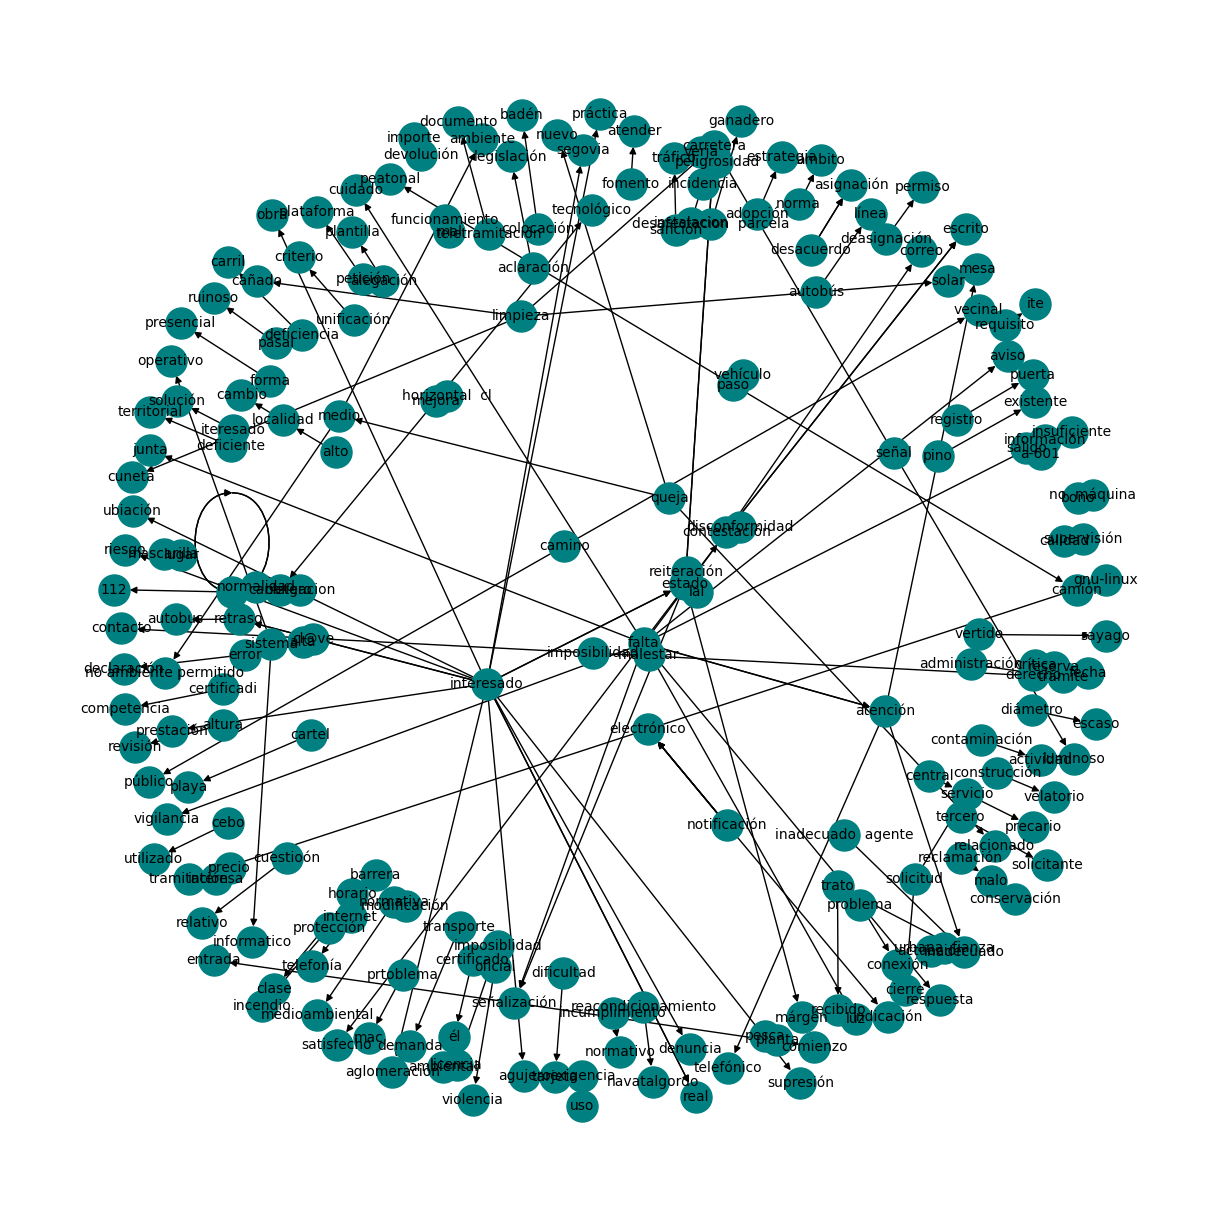

In [48]:
G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='teal', edge_cmap=plt.cm.Blues, pos = pos, font_size=10, node_size=500)
plt.show()

In [36]:
G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='teal', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

NameError: name 'kg_df' is not defined

In [310]:
entities = []
actions = []

for index in range(0, len(source) - 1):
    if (source[index] != ""):
        actions.append(relations[index])
        entities.append(source[index])
    if (target[index] != ""):
        actions.append(relations[index])
        entities.append(target[index])

entities_actions_df = pd.DataFrame({'entities':entities, 'actions':actions, 'edge':actions})

In [311]:
entities_actions_df

,entities,actions,edge
0,ayuda,haber,haber
1,beca,haber,haber
2,cuestión,ser,ser
3,rechazado,ser,ser
4,acuerdo,cantar,cantar
...,...,...,...
166,padre,ir,ir
167,incidencia,haber,haber
168,aplicación,haber,haber
169,queja,haber,haber


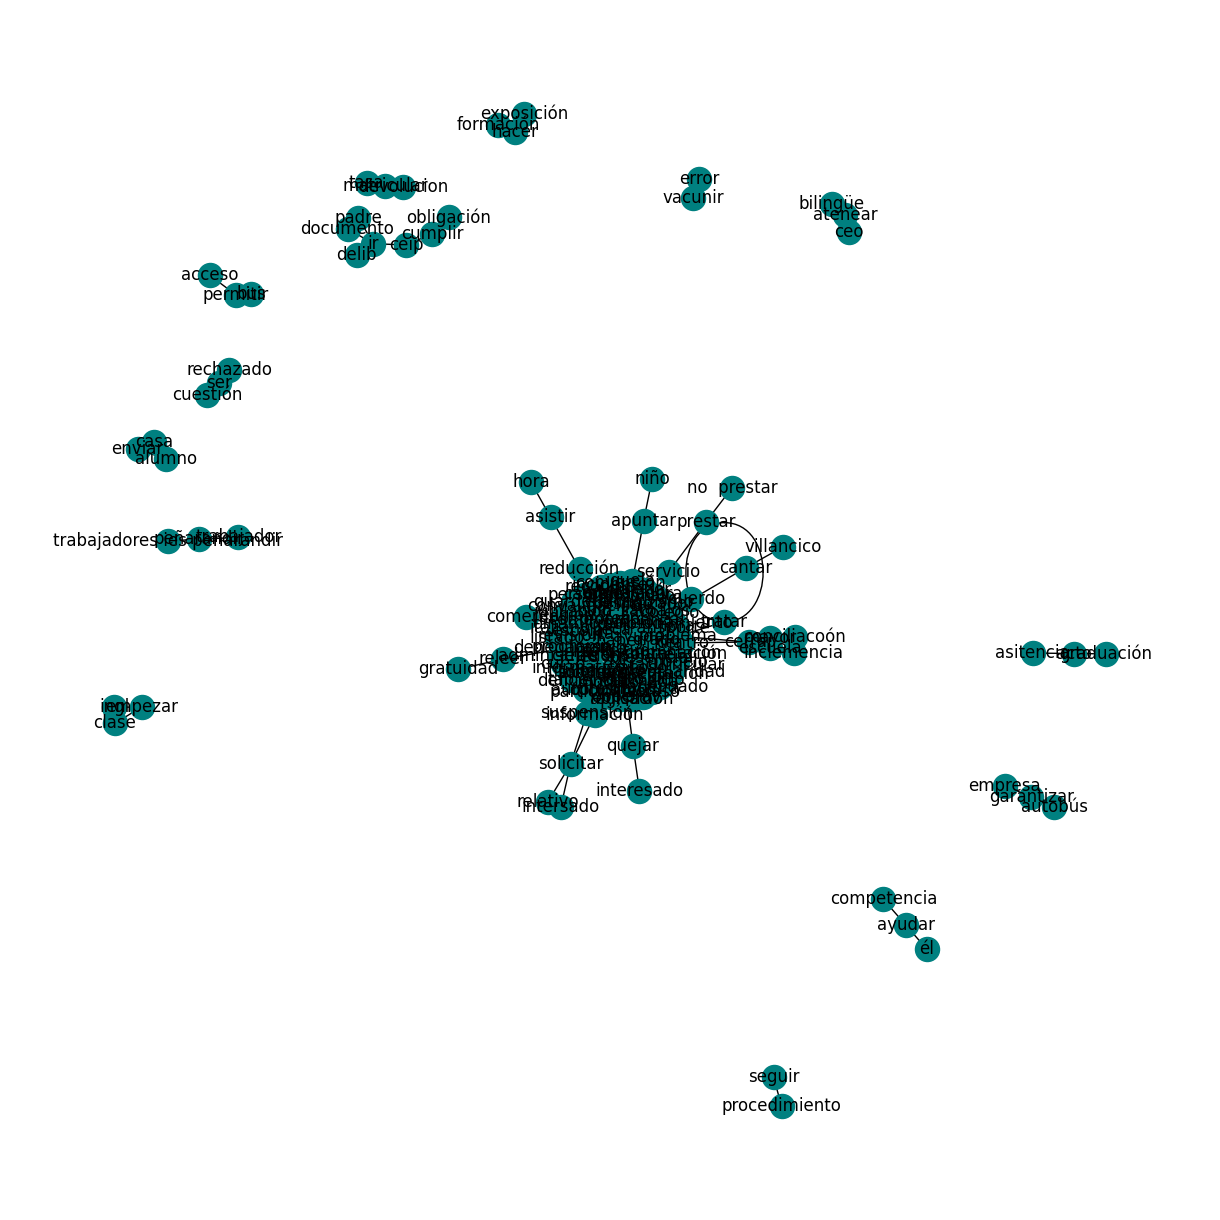

In [312]:
G = nx.from_pandas_edgelist(entities_actions_df, "entities", "actions", edge_attr=True, create_using=nx.MultiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='teal', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

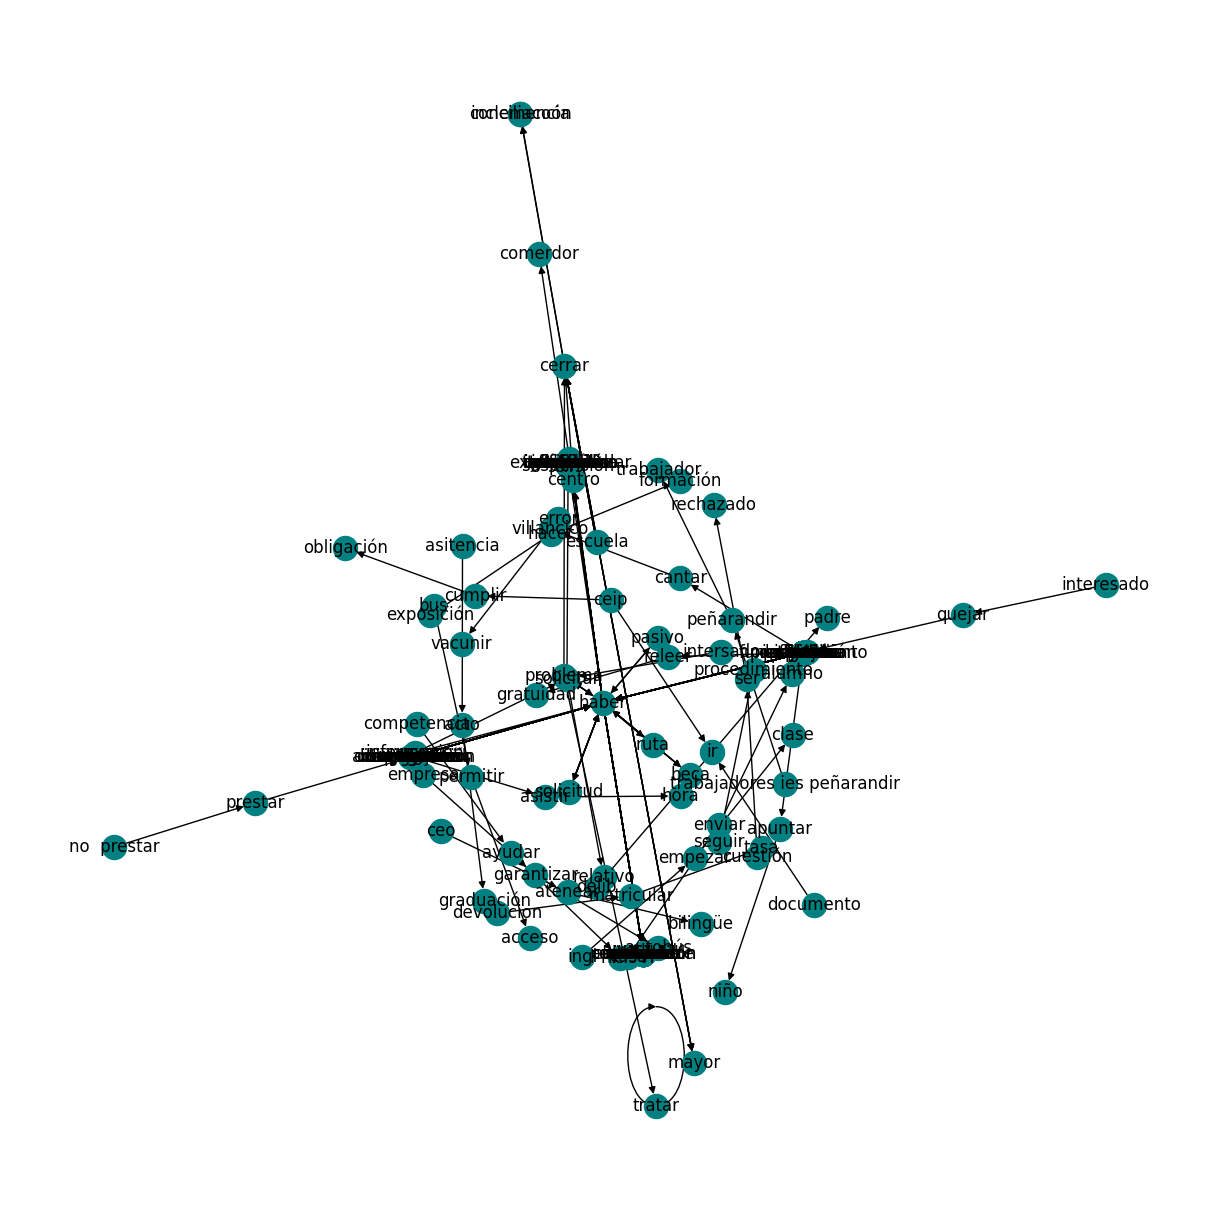

In [469]:
entities = []
actions = []

for index in range(0, len(source) - 1):
    if (source[index] != ""):
        actions.append(relations[index])
        entities.append(source[index])
    if (target[index] != ""):
        actions.append(target[index])
        entities.append(relations[index])

entities_actions_df = pd.DataFrame({'entities':entities, 'actions':actions, 'edge':actions})

G = nx.from_pandas_edgelist(entities_actions_df, "entities", "actions", edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

#pos = nx.spring_layout(G)
#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)
#pos = nx.spiral_layout(G)

nx.draw(G, with_labels=True, node_color='teal', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [452]:
import igraph as ig

import chart_studio.plotly as plotly
from plotly.offline import iplot
import plotly.graph_objs as go

In [437]:
entities = []
actions = []

for index in range(0, len(source) - 1):
    if (source[index] != ""):
        actions.append(relations[index])
        entities.append(source[index])
    if (target[index] != ""):
        actions.append(target[index])
        entities.append(relations[index])

entities_actions_df = pd.DataFrame({'entities':entities, 'actions':actions, 'edge':actions})

In [385]:
dictWords = {}
counter = 0

for word in entities:
    if word not in dictWords.keys():
        dictWords[word] = counter
        counter +=1

for word in actions:
    if word not in dictWords.keys():
        dictWords[word] = counter
        counter += 1

In [438]:
L = len(entities_actions_df["entities"])
L

171

In [439]:
Edges = [(dictWords[entities_actions_df["entities"][k]], dictWords[entities_actions_df["actions"][k]]) for k in range(L)]

In [440]:
G = ig.Graph(Edges, directed=False)

In [464]:
""" labels=[]
group=[]
for node in data['nodes']:
    labels.append(node['name'])
    group.append(node['group']) """
labels = entities_actions_df["entities"].values
group = []

In [441]:
layt = G.layout('kk', dim=3)

In [442]:
len(layt)

154

In [444]:
N = 154

In [447]:
Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
Yn=[layt[k][1] for k in range(N)]# y-coordinates
Zn=[layt[k][2] for k in range(N)]# z-coordinates
Xe=[]
Ye=[]
Ze=[]
for e in Edges:
    Xe += [layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Ye += [layt[e[0]][1],layt[e[1]][1], None]
    Ze += [layt[e[0]][2],layt[e[1]][2], None]

In [466]:


trace1=go.Scatter3d(x=Xe,
            y=Ye,
            z=Ze,
            mode='lines',
            line=dict(color='rgb(125,125,125)', width=1),
            hoverinfo='none'
            )

trace2=go.Scatter3d(x=Xn,
            y=Yn,
            z=Zn,
            mode='markers',
            name='actors',
            marker=dict(symbol='circle',
                            size=6,
                            color=group,
                            colorscale='Viridis',
                            line=dict(color='rgb(50,50,50)', width=0.5)
                            ),
            text=labels,
            hoverinfo='text'
            )

axis=dict(showbackground=False,
        showline=False,
        zeroline=False,
        showgrid=False,
        showticklabels=False,
        title=''
        )

layout = go.Layout(
        title="",
        width=1000,
        height=1000,
        showlegend=False,
        scene=dict(
            xaxis=dict(axis),
            yaxis=dict(axis),
            zaxis=dict(axis),
        ),
        margin=dict(
        t=100
    ),
    hovermode='closest',
    annotations=[
        dict(
        showarrow=False,
        text="",
        xref='paper',
        yref='paper',
        x=0,
        y=0.1,
        xanchor='left',
        yanchor='bottom',
        font=dict(
        size=14
        )
        )
    ],    )

In [459]:
import chart_studio

In [467]:
data = [trace1, trace2]
fig = go.Figure(data=data, layout=layout)

plotly.iplot(fig, filename='Les-Miserables')

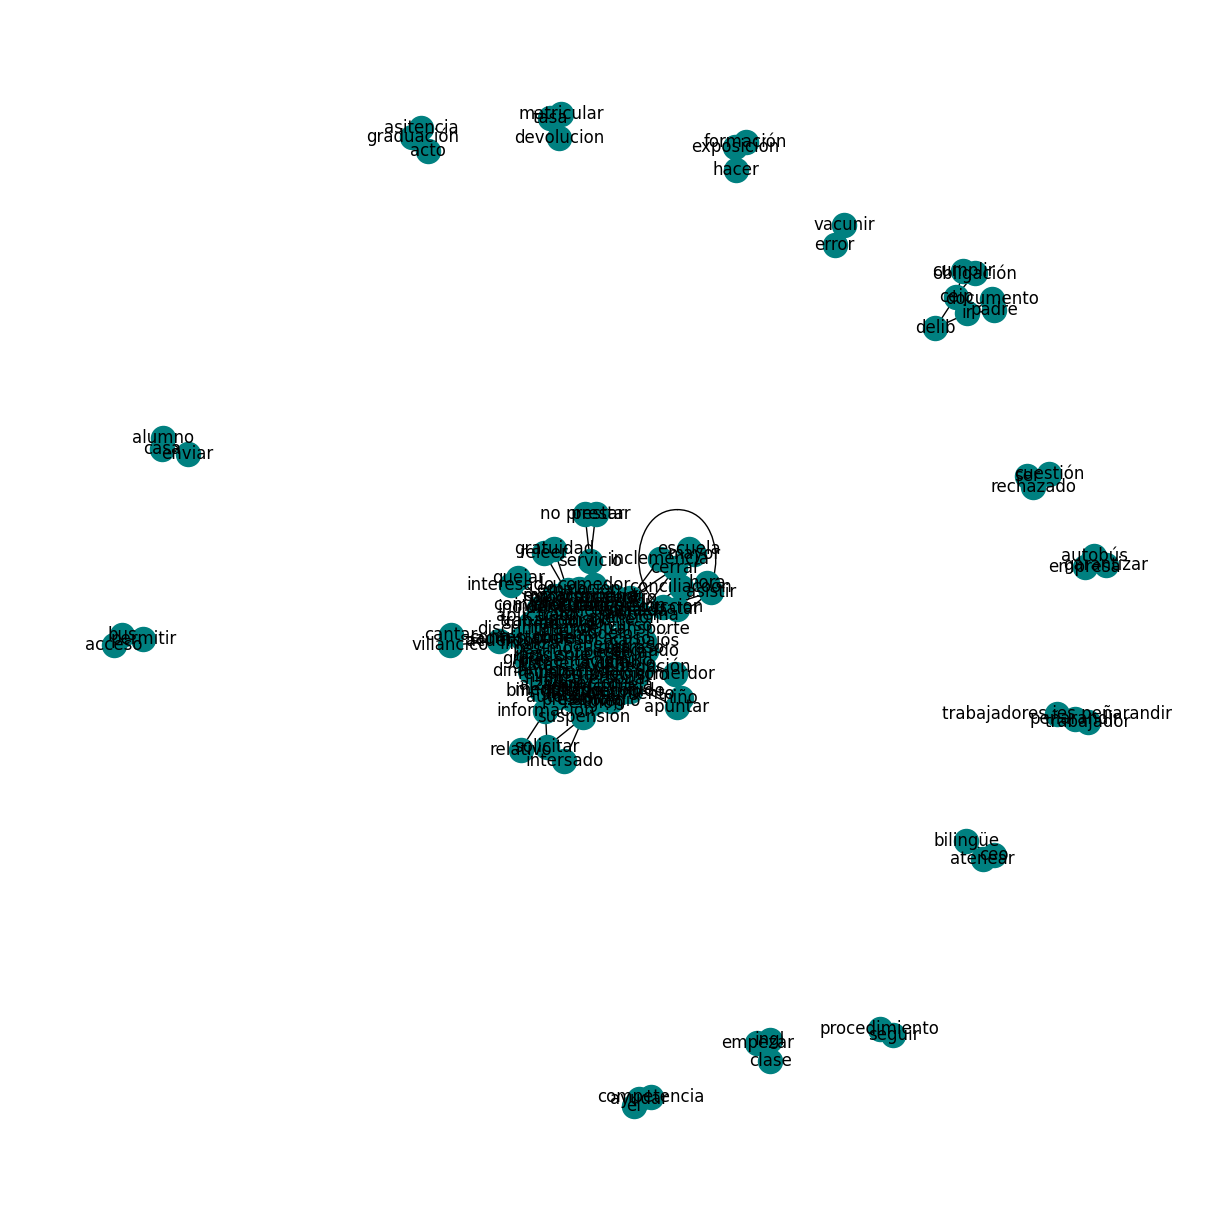

In [366]:
entities = []
actions = []

for index in range(0, len(source) - 1):
    if (source[index] != ""):
        actions.append(relations[index])
        entities.append(source[index])
    if (target[index] != ""):
        actions.append(target[index])
        entities.append(relations[index])
    if (source[index] != "" and target[index] != ""):
        actions.append(source[index])
        entities.append(target[index])

entities_actions_df = pd.DataFrame({'entities':entities, 'actions':actions, 'edge':actions})

G = nx.from_pandas_edgelist(entities_actions_df, "entities", "actions", edge_attr=True, create_using=nx.MultiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='teal', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [315]:
entities = []
actions = []

for index in range(0, len(source) - 1):
    if (source[index] != ""):
        actions.append(relations[index])
        entities.append(source[index])
    if (target[index] != ""):
        actions.append(target[index])
        entities.append(relations[index])
    if (source[index] != "" and target[index] != ""):
        actions.append(source[index])
        entities.append(target[index])

entities_actions_df = pd.DataFrame({'entities':entities, 'actions':actions, 'edge':actions})

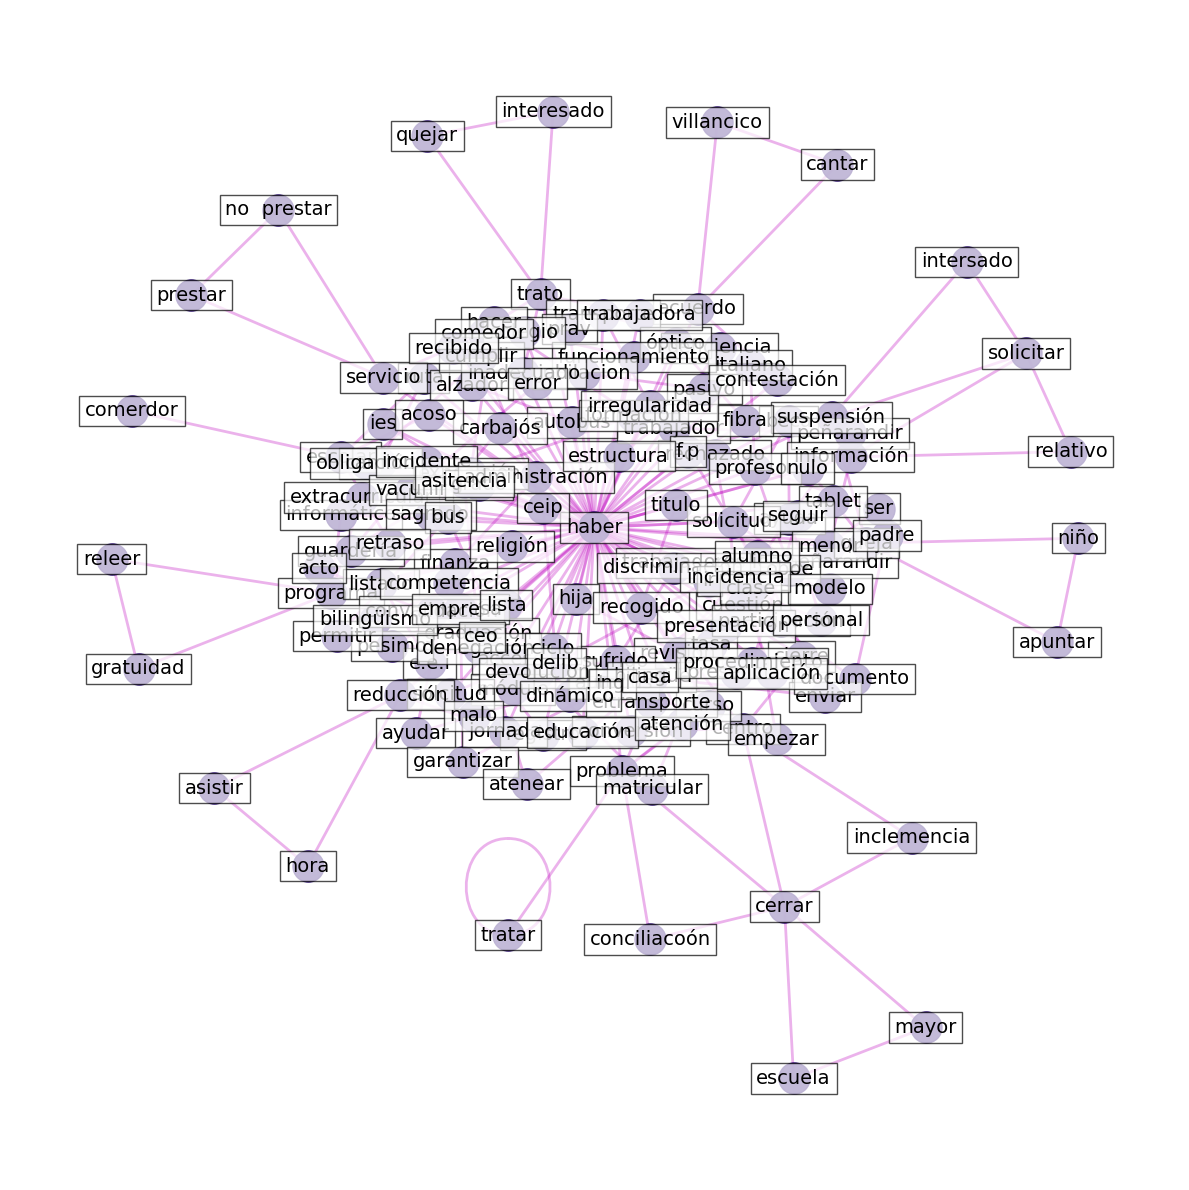

In [317]:
G = nx.MultiDiGraph()
for index in range(0, len(source) - 1):
    if (source[index] != ""):
        G.add_edge(source[index],relations[index])
    if (target[index] != ""):
        G.add_edge(target[index],relations[index])
    if (source[index] != "" and target[index] != ""):
        G.add_edge(source[index],target[index])

H = nx.Graph(G)
# edge width is proportional number of games played
#edgewidth = [len(G.get_edge_data(u, v)) for u, v in H.edges()]

pos = nx.kamada_kawai_layout(H)

fig, ax = plt.subplots(figsize=(12, 12))
# Visualize graph components
#nx.draw_networkx_edges(H, pos, alpha=0.3, width=edgewidth, edge_color="m")
nx.draw_networkx_edges(H, pos, alpha=0.3, width=2, edge_color="m")

#nx.draw_networkx_nodes(H, pos, node_size=nodesize, node_color="#210070", alpha=0.9)
nx.draw_networkx_nodes(H, pos, node_size=500, node_color="#210070", alpha=0.9)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(H, pos, font_size=14, bbox=label_options)

fig.tight_layout()
plt.axis("off")
plt.show()